In [2]:
import SymbolicRegression: SRRegressor,node_to_symbolic
import SymbolicUtils
import MLJ: machine, fit!, predict, report
using Symbolics 
include("hiddenode-1d-1a.jl")
include("hiddenode-1d-1b.jl")

train_mlp (generic function with 1 method)

In [10]:

#Generate data
rng = Random.default_rng()
Random.seed!(rng, 3)
@info "Generating data..."
t_test, Xn_test, t_train, Xn_train = generate_data()
u0 = Xn_test[:,1]
##Load the MLP
@info "Loading MLP..."
mlp, p_mlp, stM_mlp  = define_MLP(rng)

@load "/home/lucas/Projects/myKANs/KANODE/hidden-ODE/tests/test_9/checkpoints/MLP_iter30000of30000" p stM
p_mlp, stM_mlp = p, stM
##Load the KAN
@info "Loading KAN..."
kan, unused, unused = define_KAN(rng)
#This was trained before, so we can just load the checkpoint 
@load "/home/lucas/Projects/myKANs/KANODE/hidden-ODE/tests/test_5/checkpoints/KAN_iter30000of30000" p stM 
p_KAN, stM_KAN = p, stM
#Just for displaying the activation functions
Xn = reshape(Xn_train[1,:],1,:)
#@info "Displaying the KAN diagram..."
#display(plot_KAN_diagram(kan, p_KAN, stM_KAN, Xn))
phi1 =  activation_getter(kan, p_KAN, stM_KAN, 1, 1, 1)
phi2 =  activation_getter(kan, p_KAN, stM_KAN, 2, 1, 1)
# Just get the x values from the training set and reshape them into a nx1 matrix
X1 =reshape(Xn_train[1,:],:,1)


┌ Info: Generating data...
└ @ Main /home/lucas/Projects/myKANs/KANODE/hidden-ODE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:5
┌ Info: Loading MLP...
└ @ Main /home/lucas/Projects/myKANs/KANODE/hidden-ODE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:9
┌ Info: Loading KAN...
└ @ Main /home/lucas/Projects/myKANs/KANODE/hidden-ODE/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:15


1001×1 Matrix{Float32}:
 1.0
 0.9524151
 0.90909505
 0.8693329
 0.8325713
 0.7983657
 0.7663583
 0.73625904
 0.7078306
 0.680878
 ⋮
 0.050372526
 0.050374772
 0.050379302
 0.0503861
 0.05039516
 0.050406463
 0.05042
 0.05043575
 0.050453704

In [11]:
model = SRRegressor(
    niterations=50,
    binary_operators=[+, -, *],
    unary_operators=[],
)


SRRegressor(
  defaults = nothing, 
  binary_operators = Function[+, -, *], 
  unary_operators = Any[], 
  maxsize = nothing, 
  maxdepth = nothing, 
  expression_spec = nothing, 
  populations = nothing, 
  population_size = nothing, 
  ncycles_per_iteration = nothing, 
  elementwise_loss = nothing, 
  loss_function = nothing, 
  loss_function_expression = nothing, 
  dimensional_constraint_penalty = nothing, 
  parsimony = nothing, 
  constraints = nothing, 
  nested_constraints = nothing, 
  complexity_of_operators = nothing, 
  complexity_of_constants = nothing, 
  complexity_of_variables = nothing, 
  warmup_maxsize_by = nothing, 
  adaptive_parsimony_scaling = nothing, 
  mutation_weights = nothing, 
  crossover_probability = nothing, 
  annealing = nothing, 
  alpha = nothing, 
  tournament_selection_n = nothing, 
  tournament_selection_p = nothing, 
  early_stop_condition = nothing, 
  batching = nothing, 
  batch_size = nothing, 
  dimensionless_constants_only = false, 
  comp

In [12]:
#SR on the MLP
y_mlp = mlp(X1', p_mlp, stM_mlp)[1]'
mach_mlp = machine(model, X1, y_mlp)
fit!(mach_mlp)
r_mlp = report(mach_mlp)
best_eq_mlp = r_mlp.equations[r_mlp.best_idx]
mlp_symp = simplify(node_to_symbolic(best_eq_mlp); expand=true)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc SymbolicRegression.SRRegressor` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
















































































































































Evolving for 50 iterations... 100%|██████████████████████| Time: 0:00:16


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.331e-03  1.594e+01  y = 0.056754
3           6.606e-04  3.504e-01  y = x₁ * 0.48723
5           1.813e-17  7.971e+00  y = 0.031327 - (x₁ * -0.34735)
7           1.500e-17  9.484e-02  y = 0.028755 - ((x₁ + 0.007402) * -0.34735)
───────────────────────────────────────────────────────────────────────────────────────────────────


┌ Info: Final population:
└ @ SymbolicRegression /home/lucas/.julia/packages/SymbolicRegression/kbyoS/src/SymbolicRegression.jl:1149


  - outputs/20250407_164132_gPD8oQ/hall_of_fame.csv


┌ Info: Results saved to:
└ @ SymbolicRegression /home/lucas/.julia/packages/SymbolicRegression/kbyoS/src/SymbolicRegression.jl:1172


0.031326525 + (0.3473507 * x1)

In [13]:
#SR on the KAN 
y_kan = kan(X1', p, stM)[1]'
mach_kan = machine(model, X1, y_kan)
fit!(mach_kan)
r_kan = report(mach_kan)
best_eq_kan = r_kan.equations[r_kan.best_idx]
kan_symp = simplify(node_to_symbolic(best_eq_kan); expand=true)


┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc SymbolicRegression.SRRegressor` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 




































































































































































































Evolving for 50 iterations... 100%|██████████████████████| Time: 0:00:15


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.890e-03  1.594e+01  y = 0.056672
3           9.496e-04  3.441e-01  y = x₁ * 0.50325
5           1.770e-04  8.399e-01  y = x₁ * (1.0412 - x₁)
7           5.733e-05  5.637e-01  y = ((x₁ * -0.73192) + 0.89702) * x₁
9           9.417e-06  9.032e-01  y = (1.0495 - (x₁ * (1.7422 - x₁))) * x₁
11          2.213e-06  7.240e-01  y = (0.72428 * x₁) * (1.3914 - ((2.0215 - x₁) * x₁))
13          1.189e-06  3.107e-01  y = ((x₁ * 0.66726) * (1.4608 - (x₁ * (2.0656 - x₁)))) - -...
                                      0.0020264
21          5.547e-07  9.530e-02  y = (((1.4973 - x₁) - (x₁ * ((1.3786 - x₁) - ((x₁ * (1.238...
                                       - x₁)) * x₁)))) * 0.68614) * x₁
23          2.295e-07  4.413e-01  y = ((x₁ - -0.0014626) * ((1.9627 - x₁) - (((1.8844 - x₁) ...
                                      - (x₁ * ((1.417 - x₁) * 

┌ Info: Final population:
└ @ SymbolicRegression /home/lucas/.julia/packages/SymbolicRegression/kbyoS/src/SymbolicRegression.jl:1149
┌ Info: Results saved to:
└ @ SymbolicRegression /home/lucas/.julia/packages/SymbolicRegression/kbyoS/src/SymbolicRegression.jl:1172


0.0014557079 + (0.9931537 * x1) + (-1.4619612 * (x1 ^ 2)) + (0.508165 * (x1 ^ 3)) + (0.717852 * (x1 ^ 4)) + (-0.507114 * (x1 ^ 5))

In [24]:
#SR on the KAN activation functions
X2 = phi1.(X1)
X3 = phi2.(X2)
mach1 = machine(model, X1, X2)
mach2 = machine(model, X2, X3)
fit!(mach1)
fit!(mach2)
r1 = report(mach1)
r2 = report(mach2)
best_eq_r1 = r1.equations[r1.best_idx]
best_eq_r2 = r2.equations[r2.best_idx] 
expr_r1 = node_to_symbolic(best_eq_r1)
expr_r2 = node_to_symbolic(best_eq_r2)
x1 = Symbolics.get_variables(expr_r1)[1]
composed_expr = substitute(expr_r2, x1 => expr_r1)
composed_symp = simplify(composed_expr; expand=true)

0.0016109408 + (0.9677862 * x1) + (-0.7351928 * (x1 ^ 2)) + (-6.625849 * (x1 ^ 3)) + (33.56641 * (x1 ^ 4)) + (-89.37852 * (x1 ^ 5)) + (162.36287 * (x1 ^ 6)) + (-217.86388 * (x1 ^ 7)) + (224.32101 * (x1 ^ 8)) + (-180.89285 * (x1 ^ 9)) + (115.39434 * (x1 ^ 10)) + (-58.369186 * (x1 ^ 11)) + (23.309132 * (x1 ^ 12)) + (-7.266753 * (x1 ^ 13)) + (1.7353157 * (x1 ^ 14)) + (-0.30857062 * (x1 ^ 15)) + (0.039277613 * (x1 ^ 16)) + (-0.0033966945 * (x1 ^ 17)) + (0.00018635059 * (x1 ^ 18)) + (-5.791745e-6 * (x1 ^ 19)) + (7.7241474e-8 * (x1 ^ 20))

In [26]:
@show mlp_symp
@show kan_symp
@show composed_symp

println("Best Equation MLP: ", mlp_symp )
println("Best Equation KAN: ", kan_symp )
println("Composed Equation: ", composed_symp)
#= For SR on the whole KAN =# 

#Note to self April 4 5:40pm. I almost have this working
#but when I was training the MLP I lost the checkpoint. 
#This was in test5, so the KAN was trained correctly but 
#not the MLP. I need to train the MLP again, BUT it im running
#into some problem where it takes a long time to train. I think
#this is due to an error somewhere, but maybe Im wrong? This
#is where you need to pick up where I left off.

Here I'll plot the KAN and the MLP vs the true function

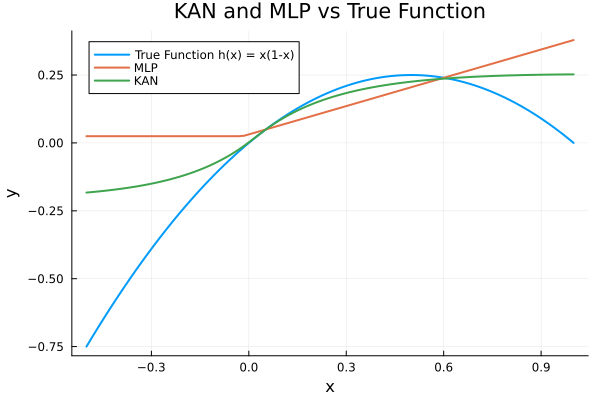

In [35]:
using Plots

# Define the true function
h(x) = x * (1 - x)

# Generate x values over the interval [-1, 2]
x_vals = range(-0.5, 1, length=100)

# Compute true function values
h_vals = h.(x_vals)

# Compute MLP and KAN predictions
mlp_vals = mlp(x_vals', p_mlp, stM_mlp)[1]'
kan_vals = kan(x_vals', p_KAN, stM_KAN)[1]'

# Plot the results
plot(x_vals, h_vals, label="True Function h(x) = x(1-x)", lw=2)
plot!(x_vals, mlp_vals, label="MLP", lw=2)
plot!(x_vals, kan_vals, label="KAN", lw=2)
xlabel!("x")
ylabel!("y")
title!("KAN and MLP vs True Function")

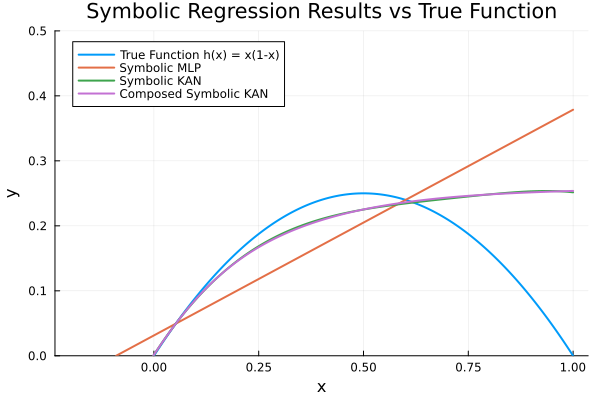

In [70]:
# Generate x values over the interval [-0.5, 1]
x_vals_sr = Matrix(reshape(range(-0.2, 1, length=1000), :, 1))
# Compute true function values
h_vals = h.(x_vals_sr)
# Compute symbolic regression predictions
mlp_sr_vals = predict(mach_mlp, x_vals_sr)
kan_sr_vals = predict(mach_kan, x_vals_sr)
y1 = reshape(predict(mach1, x_vals_sr), :, 1)
composed_sr_vals = predict(mach2, y1)
# Plot the results
plot(x_vals_sr, h_vals, label="True Function h(x) = x(1-x)", lw=2)
plot!(x_vals_sr, mlp_sr_vals, label="Symbolic MLP", lw=2)
plot!(x_vals_sr, kan_sr_vals, label="Symbolic KAN", lw=2)
plot!(x_vals_sr, composed_sr_vals, label="Composed Symbolic KAN", lw=2)
xlabel!("x")
ylabel!("y")
ylims!(0, 0.5)
title!("Symbolic Regression Results vs True Function")

In [69]:
# Print the best equations
println("Best Equation MLP: ", mlp_symp)
println("Best Equation KAN: ", kan_symp)
println("Composed Equation: ", composed_symp)

In [68]:
print("HI")

In [ ]:
asdasd